# Cancer Detection Using CNN

<p><strong>Name: </strong>Josiah Ball<br>
<strong>Date: </strong>4/21/2025<br>
<strong>Course: </strong>DTSA 5511</p>

<p>The purpose of this lab is to glorify Jesus Christ by creating a convolutional neural network that can accurately predict benign and malignant cancer cells, in submission to the <a href="https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview" target="_blank">"Histopathologic Cancer Detection" Kaggle competition</a> [1]. The intended audience of this project is my fellow students at the University of Colorado at Boulder as well as the Kaggle co-competitors.</p>


## The Problem

<p>The goal of this project is to create a convolutional neural networks (CNN) which can take a medical image from the PCam dataset and predict whether the cells are cancerous or non-cancerous. The input for the CNN is a 32px by 32px center of an image, and the output of the is a binary classification (0 being benign or 1 being malignant).</p>

## The Dataset

<p>The training dataset is composed of 220,025 images of varying sizes, of which the central 32px by 32px square is labelled as "1" if there exists a malignant (cancerous) cell within the center, and "0" otherwise representing a benign (non-cancerous) cell. This dataset has already been cleaned to remove duplicate images from the original PCam dataset</p>

## Notebook Set Up

<p>Before running exploratory data analysis (EDA), we will initialize the notebook by loading our libraries, ensuring we are running on a GPU (via AWS SageMaker), setting up Kaggle CLI, and downloading our dataset.</p>

In [ ]:
# Install Libraries if needed
# !pip install

In [23]:
# Import Libraries
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image

import tensorflow as tf 
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import load_model

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # This tells TensorFlow to ignore all GPUs

In [2]:
# Check GPU Usage
try:
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        raise RuntimeError("🚫 No GPU detected.")
    else:
        print(f"✅ GPU detected: {gpus[0].name}")
except Exception as e:
    print(f"Error: {e}")

Error: 🚫 No GPU detected.


2025-04-23 02:10:14.579700: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-23 02:10:14.579751: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: default
2025-04-23 02:10:14.579762: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: default
2025-04-23 02:10:14.579949: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.144.3
2025-04-23 02:10:14.579973: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.144.3
2025-04-23 02:10:14.579980: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.144.3


<p><strong>NOTE: </strong>I could not configure my GPU correctly, so that is why I included <code>os.environ["CUDA_VISIBLE_DEVICES"] = "-1"</code> in order to ignore the existing GPU. This resulted in very slow model training and a limit of 5 epochs per model.</p>

## Upload dataset from Kaggle

In [ ]:
# # Create .kaggle folder in home directory
# os.makedirs(Path.home() / ".kaggle", exist_ok=True)

# # Move kaggle.json into the folder and set permissions
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
#!kaggle competitions download -c histopathologic-cancer-detection

In [ ]:
# Unzip dataset
#!unzip -q histopathologic-cancer-detection.zip -d histopathologic-cancer-detection

## Exploratory Data Analysis (EDA)

<p>Next, we will run some EDA in order to better understand the dataset before training our model.</p>

<p>Recall from the Kaggle competition that duplicates have already been removed, so we do not have to worry about duplicate removal.</p>

In [3]:
# Create df with labels and image filepath
labels_path = "histopathologic-cancer-detection/train_labels.csv"
df = pd.read_csv(labels_path)
df['image_path'] = df['id'].apply(lambda x: os.path.join("histopathologic-cancer-detection/train", f"{x}.tif"))
print(df.shape)
df.head()

(220025, 3)


,id,label,image_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,histopathologic-cancer-detection/train/f38a637...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,histopathologic-cancer-detection/train/c18f2d8...
2,755db6279dae599ebb4d39a9123cce439965282d,0,histopathologic-cancer-detection/train/755db62...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,histopathologic-cancer-detection/train/bc3f0c6...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,histopathologic-cancer-detection/train/068aba5...


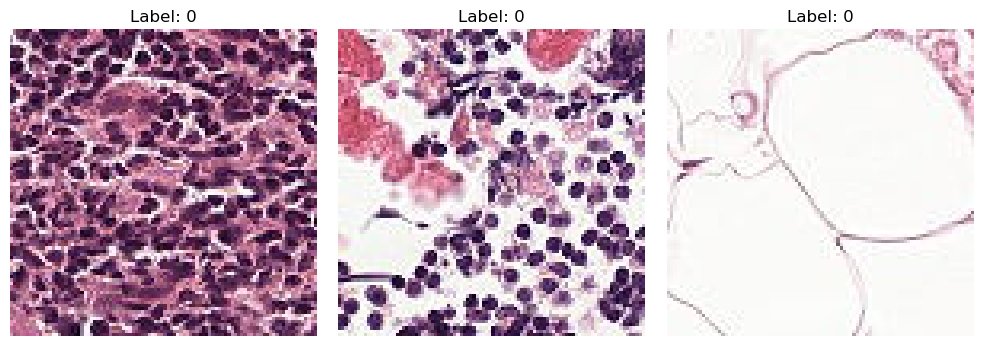

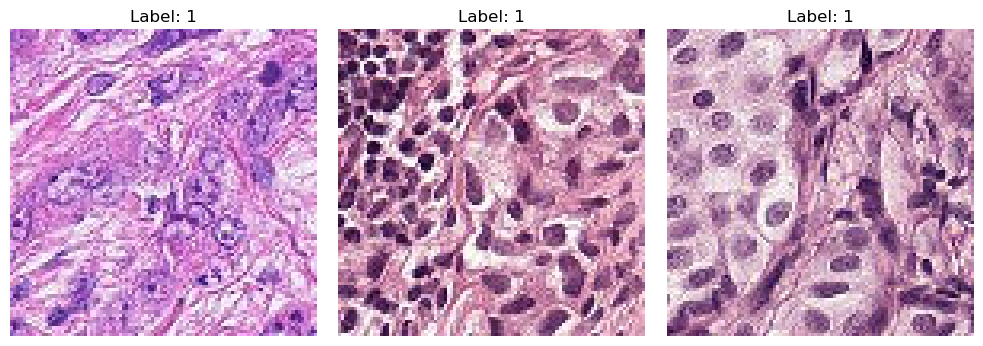

In [4]:
# Inspect the images
def show_images(label, n=3):
    sample_ids = df[df['label'] == label].sample(n)['id'].values
    plt.figure(figsize=(10, 10))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join('histopathologic-cancer-detection', 'train', img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {label}")
    plt.tight_layout()
    plt.show()

# Show samples from each class
show_images(label=0)
show_images(label=1)

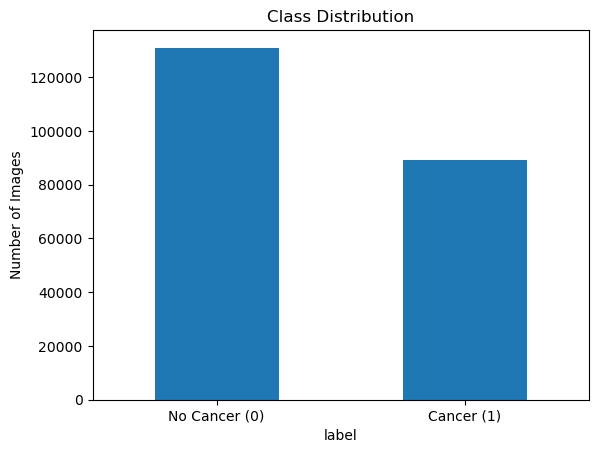

label
0    0.594969
1    0.405031
Name: count, dtype: float64


In [5]:
# Check for class imbalance
class_counts = df['label'].value_counts()

class_counts.plot(kind='bar', title='Class Distribution')
plt.xticks([0,1], ['No Cancer (0)', 'Cancer (1)'], rotation=0)
plt.ylabel('Number of Images')
plt.show()

print(class_counts/len(df))

<p><strong>NOTE:</strong> becuase there is a slight imbalance in the dataset, we will:</p>
    
<ul><li>Stratify our train and validation split.</li>
<li>Evaluate the results using other metrics than accuracy, such as AUC-ROC, precision, and recall.</li></ul>

<p>However, since the data imbalance is not overly severe, we will NOT utilize resampling techniques or integrate class weights into model training. these will remain as possible steps for improvement if needed in our concluding discussion.</p>

In [6]:
# Train/Validation Split
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(df.shape)
print(df_train.shape)
print(df_val.shape)

(220025, 3)
(176020, 3)
(44005, 3)


<p><strong>NOTE:</strong> To ensure uniform and normalized input, we will resize all images to be 96x96px and normalize the pixel inputs.</p>

In [7]:
# Normalize Training/Validation Inputs
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=32
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [16]:
# Normalize Testing Inputs
TEST_DIR = 'histopathologic-cancer-detection/test/'
test_files = os.listdir(TEST_DIR)

df_test = pd.DataFrame({
    'id': [os.path.splitext(file)[0] for file in test_files],
    'filename': test_files,
    'filepath': [os.path.join(TEST_DIR, fname) for fname in test_files]
})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepath',
    y_col=None, 
    target_size=(96, 96),
    class_mode=None,
    batch_size=32,
    shuffle=False
)

Found 57458 validated image filenames.


## Model Training

<p>In this lab, we will build and compare the performance of two models:</p>

<ul>
    <li>Basic CNN 
        <ul>
            <li>Architecture: Two convolutional layers then a dense classifier</li>
            <li>Optimizing Method: Adam</li>
            <li>Pooling Method: Max Pooling</li>
            <li>Loss Function: Binary Cross Entropy</li>
            <li>Evaluation Metrics: Accuracy, AUC-ROC, Precision, and Recall</li>
        </ul>
    </li>
    <li>CNN with Dropout and Batch Normalization
        <ul>
            <li>Architecture: Two convolutional layers then a dense classifier, each with dropout and batch normalization</li>
            <li>Optimizing Method: Adam</li>
            <li>Pooling Method: Max Pooling</li>
            <li>Loss Function: Binary Cross Entropy</li>
            <li>Evaluation Metrics: Accuracy, AUC-ROC, Precision, and Recall</li>
        </ul>
    </li>
</ul>

### Model 1: Basic CNN

In [8]:
# Train Basic CNN
def build_basic_cnn(input_shape=(96, 96, 3)):
    model = models.Sequential()
    
    # Conv Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) 

    return model

model = build_basic_cnn()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model.summary()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001,985 (7.64 MB)

 Trainable params: 2,001,985 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Fit the Model
basic_CNN = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 415s 75ms/step - accuracy: 0.9316 - auc: 0.9809 - loss: 0.1729 - precision: 0.9221 - recall: 0.9084 - val_accuracy: 0.8640 - val_auc: 0.9315 - val_loss: 0.3609 - val_precision: 0.8352 - val_recall: 0.8275
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 422s 77ms/step - accuracy: 0.9495 - auc: 0.9884 - loss: 0.1332 - precision: 0.9427 - recall: 0.9321 - val_accuracy: 0.8559 - val_auc: 0.9234 - val_loss: 0.4729 - val_precision: 0.8071 - val_recall: 0.8465
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 419s 76ms/step - accuracy: 0.9631 - auc: 0.9931 - loss: 0.1011 - precision: 0.9586 - recall: 0.9504 - val_accuracy: 0.8526 - val_auc: 0.9208 - val_loss: 0.4906 - val_precision: 0.8234 - val_recall: 0.8099
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 407s 74ms/step - accuracy: 0.9724 - auc: 0.9958 - loss: 0.0763 - precision: 0.9705 - recall: 0.9615 - val_accuracy: 0.8458 - val_auc: 0.9116 - val_loss: 0.6295 - val_precision: 0.7914 - val_recall: 0.8410
Epoch 5/5
5501/5

### Model 2: CNN with Dropout and Batch Normalization

<p><strong>NOTE:</strong> This model has the same architecture as the basic CNN above but introduces dropout and batch normalization.</p>

In [18]:
# Train Basic CNN
def build_cnn_dropout_batch(input_shape=(96, 96, 3), dropout_rate=0.5):
    model = models.Sequential()
    
    # Conv Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    # Conv Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid')) 

    return model

drop_batch_model = build_cnn_dropout_batch()

drop_batch_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

drop_batch_model.summary()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,625 (7.64 MB)

 Trainable params: 2,002,305 (7.64 MB)

 Non-trainable params: 320 (1.25 KB)

In [19]:
# Fit the Model
CNN_dropout_batch = drop_batch_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 646s 117ms/step - accuracy: 0.7858 - auc: 0.8493 - loss: 0.4773 - precision: 0.7520 - recall: 0.7067 - val_accuracy: 0.7943 - val_auc: 0.9123 - val_loss: 0.4565 - val_precision: 0.6876 - val_recall: 0.9017
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 636s 116ms/step - accuracy: 0.8307 - auc: 0.8981 - loss: 0.3923 - precision: 0.8173 - recall: 0.7496 - val_accuracy: 0.7487 - val_auc: 0.9190 - val_loss: 0.5345 - val_precision: 0.6263 - val_recall: 0.9409
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 617s 112ms/step - accuracy: 0.8437 - auc: 0.9110 - loss: 0.3685 - precision: 0.8275 - recall: 0.7750 - val_accuracy: 0.8587 - val_auc: 0.9164 - val_loss: 0.3568 - val_precision: 0.8501 - val_recall: 0.7904
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 617s 112ms/step - accuracy: 0.8496 - auc: 0.9199 - loss: 0.3519 - precision: 0.8341 - recall: 0.7885 - val_accuracy: 0.8559 - val_auc: 0.9371 - val_loss: 0.3394 - val_precision: 0.7895 - val_recall: 0.8785
Epoch 5/5
55

## Model Comparisons

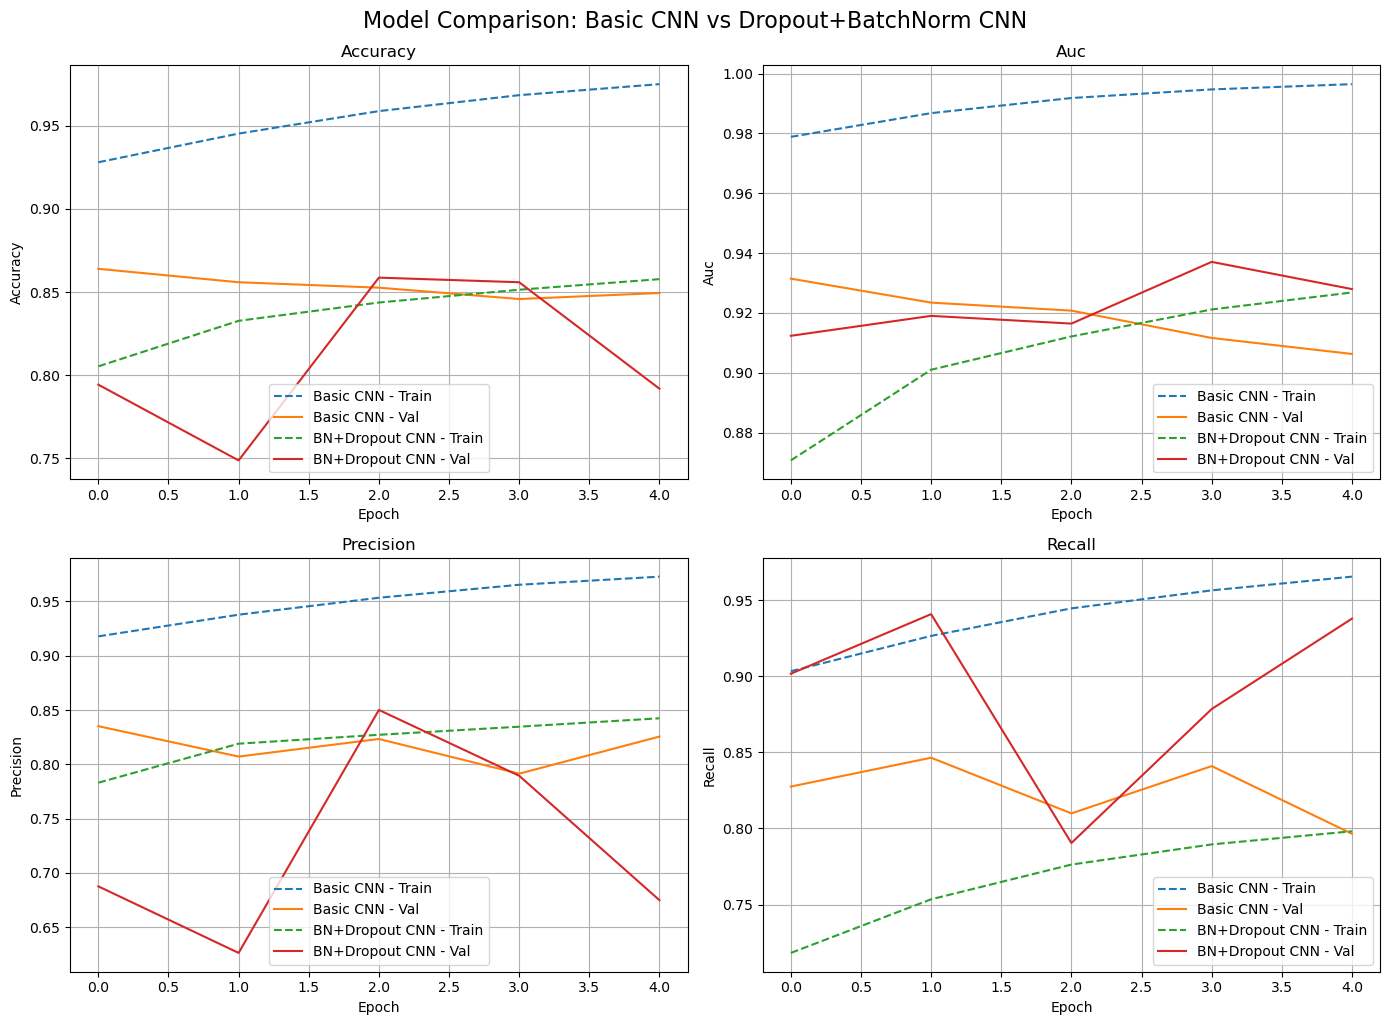

In [20]:
# Define metrics to compare
metrics = ['accuracy', 'auc', 'precision', 'recall']

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Plot basic CNN
    ax.plot(basic_CNN.history[metric], label='Basic CNN - Train', linestyle='--')
    ax.plot(basic_CNN.history[f'val_{metric}'], label='Basic CNN - Val')

    # Plot CNN with Dropout + BatchNorm
    ax.plot(CNN_dropout_batch.history[metric], label='BN+Dropout CNN - Train', linestyle='--')
    ax.plot(CNN_dropout_batch.history[f'val_{metric}'], label='BN+Dropout CNN - Val')

    ax.set_title(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Model Comparison: Basic CNN vs Dropout+BatchNorm CNN", fontsize=16, y=1.02)
plt.show()

### Interpretation 

<p>The graphs above tell us a few stories:</p>

<ul>
    <li>The basic CNN model consistently showed patterns of overfitting, such as:
        <ul>
            <li>Increasing accuracy, AUC-ROD, precision and recall on the training data while decreasing accuracy, AUC-ROD, precision and recall on the validatioon data.</li>
            <li>Large gap between the trainig performance and the validation performance</li>
        </ul>
    </li>
    <li>The CNN with dropout and batch normalization (unsurprisingly) overfit less, evidenced by the roughly equivalent or even improved performance of the model on the validation data against the training data. this means it generalized better than the basic CNN.</li>
    <li>However, the CNN with dropout and batch normalization did begin to show signs of overfitting from epoch 4 onwards. Epochs 2 and 3 seemed to have the best performance across the board on the validation dataset.</li>
    <li>At epoch 3, the CNN with dropout and batch normalization outperformed the basic CNN for each metric on the validation dataset. </li>
</ul>

<p><strong>We conclude that the CNN with dropout and batch normalization at epoch 3 was the better model, and we will predict the test dataset using this model.</strong></p>

In [21]:
drop_batch_model.fit(train_generator, validation_data=val_generator, epochs=3)
drop_batch_model.save("final_basic_model_epoch3.h5")

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 641s 117ms/step - accuracy: 0.8617 - auc: 0.9305 - loss: 0.3286 - precision: 0.8440 - recall: 0.8069 - val_accuracy: 0.8769 - val_auc: 0.9429 - val_loss: 0.3021 - val_precision: 0.8564 - val_recall: 0.8361
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 631s 115ms/step - accuracy: 0.8649 - auc: 0.9335 - loss: 0.3222 - precision: 0.8498 - recall: 0.8107 - val_accuracy: 0.8144 - val_auc: 0.9389 - val_loss: 0.4115 - val_precision: 0.7002 - val_recall: 0.9471
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 627s 114ms/step - accuracy: 0.8696 - auc: 0.9372 - loss: 0.3132 - precision: 0.8546 - recall: 0.8180 - val_accuracy: 0.8073 - val_auc: 0.9392 - val_loss: 0.4351 - val_precision: 0.6901 - val_recall: 0.9514


## Run On Test Data

In [25]:
# Load the final model
final_model = load_model("final_basic_model_epoch3.h5")

# Predict test data
pred_probs = final_model.predict(test_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
df_test['label'] = pred_labels

# Save submission as .csv
submission = df_test[['id', 'label']]
submission.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 100s 56ms/step


<p><strong>NOTE: </strong>This model had a public score of <strong>0.8109</strong> on the testing data.</p>

## Discussion

<p><strong>Summary: </strong>In this notebook, we:</p>

<ul>
    <li>Overviewed the problem</li>
    <li>Explored the data</li>
    <li>Normalized the data</li>
    <li>Built a basic CNN</li>
    <li>Built a basic CNN that also uses dropout and batch normalization</li>
    <li>Compared the two models</li>
    <li>Predicted the test data labels using the CNN with dropout and batch normalization model</li>
</ul>

<p><strong>Results and Takeaways: </strong>From this, we saw:</p>

<ul>
    <li>The basic CNN was overfit</li>
    <li>Adding dropout and batch normalization not only reduced overfitting but also increased performance</li>
</ul>

<p><strong>Limitations: </strong>Some of the limitations of this notebook include:</p>

<ul>
    <li>The GPU could not be configured, so we had to run on the CPU</li>
    <li>Because of the slow CPU speed, the epochs had to be limited to 5</li>
    <li>The only hyperparameter that we tested was dropout and batch normalization. In a production context, this should be expanded to tune the hyperparaters listed below.</li>
</ul>

<p><strong>Next Steps: </strong>If we were to continue iterating, some possible next steps include:</p>

<ul>
    <li>Run on a machine with a GPU and test varying epoch counts</li>
    <li>Experiment with optimization methods other than Adam (SGD with momentum, AdaGrad, and RMSProp)</li>
    <li>Experiment with differing batch sizes</li>
    <li>Experiment with differing learning rates</li>
    <li>Experiment with differing architectures, such as:
        <ul>
            <li>More convolution layers</li>
            <li>Different activation functions</li>
            <li>Different filter sizes</li>
            <li>Different regularization methods</li>
            <li>Different classifier NN sizes</li>
        </ul>
    </li>
</ul>

# Works Cited
[1] Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.<br>
[2] Entire Notebook was completed with the assistance of ChatGPT.